In [1]:
# -*- coding: utf-8 -*-
"""
This is a workflow intended to expedite the processing of flow properties from CenCOOS 2km HF Radar Data
Optimized to run on Eady (eady.caltech.edu)

Please utilize the Dask distributed Client scheduler for best results
Last Updatedd 06/18/2020 Thursday
"""
from IPython.core.display import display, HTML # Widen jupyter notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
# Setup Distributed Client
autostart = True
if autostart:
    pass # just let it use the dask lab extension cluster
else:
    from dask.diagnostics import ProgressBar
    from dask.distributed import Client
    from dask.distributed import LocalCluster
    # client = Client('localhost:8787') # Connect to old dashboard?
    try:
        client = Client('tcp://localhost:8786', timeout='2s')
    except OSError:
        cluster = LocalCluster(scheduler_port=8786)
        client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:36076 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 134.93 GB


In [47]:
#%% Setup Packages
import xarray as xr
from xarray import open_mfdataset
import dask
import dask.array as da
import netCDF4 as netcdf
import numpy as np
import pandas as pd
import scipy.stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import metpy.calc as mpcalc
from metpy.units import units

import sys
import os
import glob
import re
from importlib import reload

sys.path.insert(1,r"/export/home1/jbenjami/Research_Thompson/Python/personal/")
print(sys.path)
import personal

import personal.math as pm
import personal.statistics as ps
import personal.data_structures
import personal.date_operations
import personal.date_operations as pdo
import personal.SMODE
import personal.plots
import personal.IO
import datetime as dt
import gc; gc.collect()

#%% Plot setup
dpi = 100
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

['/export/home1/jbenjami/Research_Thompson/Python', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/Research_Thompson/Python/personal/', '/export/home1/jbenjami/anaconda3/lib/python37.zip', '/export/home1/jbenjami/anaconda3/lib/python3.7', '/export/home1/jbenjami/anaconda3/lib/python3.7/lib-dynload', '', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages', '/export/home1/jbenjami/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/export/home1/jbenjami/.ipython']


In [3]:
#file_path = os.path.abspath(os.path.dirname(__file__)) # works locally but not in notebook
file_path    = os.path.abspath(os.path.dirname(''))
data_relpath = "../Data/HF_Radar/2km/processed/smode_region/"
data_source  = os.path.normpath(os.path.join(file_path, data_relpath))

In [4]:
velocity                = xr.open_mfdataset(data_source+'/velocity/*.nc*'               , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
gradients               = xr.open_mfdataset(data_source+'/gradients/*.nc*'              , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy          = xr.open_mfdataset(data_source+'/kinetic_energy/*.nc*'         , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
velocity_smoothed       = xr.open_mfdataset(data_source+'/smoothed/velocity/*.nc*'      , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
gradients_smoothed      = xr.open_mfdataset(data_source+'/smoothed/gradients/*.nc*'     , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed
kinetic_energy_smoothed = xr.open_mfdataset(data_source+'/smoothed/kinetic_energy/*.nc*', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override",parallel=True) # chunked this way for speed, since we are now just saving calcs to disk... decoding times seems to work, dask chunks for speed

In [5]:
#%% Calculate stats along time
# Calculate Vorticity Stats
def moment_calc(x):
    import scipy.stats # for some reason can't be read from outside the func? if not loaded interiorly yields error: module 'scipy' has no attribute 'stats'
    nonmean_moments = [2,3,4]
#     print(x.shape)
    moments = np.array([np.nanmean(x, dtype=np.float64)] + [scipy.stats.moment(x, moment=mom, axis=None, nan_policy = 'omit') for mom in nonmean_moments]) # written this way so can be parallelized along loop
    return moments

# stats = xr.apply_ufunc(moment_calc, smode_data.merge((smode_data**2).rename({x:x + '_2' for x in smode_data.data_vars})), dask = "parallelized", vectorize=True, input_core_dims=[["lon","lat"]],output_core_dims=[['moment']], output_dtypes=[smode_data['vorticity'].dtype], output_sizes={'moment':4}).rename().assign_coords({'moment':[1,2,3,4]})#,  exclude_dims=set(("lat","lon")),)

gradients_stats         = xr.apply_ufunc(moment_calc, 
                                         gradients.drop(['gradients','deriv']),
                                         dask = "parallelized",
                                         vectorize=True,
                                         input_core_dims=[["lon","lat"]],
                                         exclude_dims=set(("lat","lon")),
                                         output_core_dims=[('dim0',)],
                                         output_dtypes=[gradients['vorticity'].dtype],
                                         dask_gufunc_kwargs = {'output_sizes':{'dim0':4}} # apparently you have to use a generic name, see https://github.com/pydata/xarray/issues/4399#issuecomment-685327243
                                        ).rename_dims({'dim0':'moment'}).assign_coords({'moment':[1,2,3,4]})#,  

KE_stats                = xr.apply_ufunc(moment_calc, 
                                         kinetic_energy.drop(['u_p','v_p']).sel(baseline=""),
                                         dask = "parallelized",
                                         vectorize=True,
                                         input_core_dims=[["lon","lat"]],
                                         exclude_dims=set(("lat","lon")),
                                         output_core_dims=[('dim0',)],
                                         output_dtypes=[kinetic_energy['KE'].dtype],
                                         dask_gufunc_kwargs = {'output_sizes':{'dim0':4}} # apparently you have to use a generic name, see https://github.com/pydata/xarray/issues/4399#issuecomment-685327243
                                        ).rename_dims({'dim0':'moment'}).assign_coords({'moment':[1,2,3,4]})#,  

EKE_baseline_all_stats  = xr.apply_ufunc(moment_calc, 
                                         kinetic_energy.drop(['u_p','v_p']).sel(baseline="all"),
                                         dask = "parallelized",
                                         vectorize=True,
                                         input_core_dims=[["lon","lat"]],
                                         exclude_dims=set(("lat","lon")),
                                         output_core_dims=[('dim0',)],
                                         output_dtypes=[kinetic_energy['KE'].dtype],
                                         dask_gufunc_kwargs = {'output_sizes':{'dim0':4}} # apparently you have to use a generic name, see https://github.com/pydata/xarray/issues/4399#issuecomment-685327243
                                        ).rename_dims({'dim0':'moment'}).assign_coords({'moment':[1,2,3,4]})#,  

In [117]:
# stats.chunk({'time':time_chunk//13}).to_netcdf(path=save_file + '.nc') # is this faster than saving in parallel (say daily or monthly files or something) for speed boost and then merging the much smaller outputs?
# stats_big_chunks.to_netcdf(path=save_file + '_big_chunks.nc') # is this faster than saving in parallel (say daily or monthly files or something) for speed boost and then merging the much smaller outputs?
# gradients_stats_fulltime.to_netcdf(       path = data_source+'/analysis/stats/gradients_stats_fulltime'        + '.nc',mode='w')


In [6]:
# save by year
personal.data_structures.xr_save_by_date_strtfmt(gradients_stats       ,filepath=data_source+'/analysis/stats/', filename_prefix=       'gradients_stats',  fmt_string='%Y', return_filenames_datasets=True)
personal.data_structures.xr_save_by_date_strtfmt(KE_stats              ,filepath=data_source+'/analysis/stats/', filename_prefix=              'KE_stats',  fmt_string='%Y', return_filenames_datasets=True)
personal.data_structures.xr_save_by_date_strtfmt(EKE_baseline_all_stats,filepath=data_source+'/analysis/stats/', filename_prefix='EKE_baseline_all_stats',  fmt_string='%Y', return_filenames_datasets=True)

# merge to one file and save
gradients_stats_fulltime        = xr.open_mfdataset(data_source+'/analysis/stats/gradients_stats_20*.nc'       , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override", parallel=True)
KE_stats_fulltime               = xr.open_mfdataset(data_source+'/analysis/stats/KE_stats_20*.nc'              , decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override", parallel=True)
EKE_baseline_all_stats_fulltime = xr.open_mfdataset(data_source+'/analysis/stats/EKE_baseline_all_stats_20*.nc', decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal", coords="minimal", compat="override", parallel=True)

gradients_stats_fulltime.to_netcdf(       path = data_source+'/analysis/stats/gradients_stats_fulltime'        + '.nc',mode='w')
KE_stats_fulltime.to_netcdf(              path = data_source+'/analysis/stats/KE_stats_fulltime'               + '.nc')
EKE_baseline_all_stats_fulltime.to_netcdf(path = data_source+'/analysis/stats/EKE_baseline_all_stats_fulltime' + '.nc')

# cleanup
_ = [os.remove(file) for file in glob.glob(data_source+'/analysis/stats/' + '*_20*.nc') ]

In [7]:
# load data
gradients_stats_fulltime        = xr.open_dataset(data_source+'/analysis/stats/gradients_stats_fulltime.nc'       , decode_cf=True, decode_times=True)
KE_stats_fulltime               = xr.open_dataset(data_source+'/analysis/stats/KE_stats_fulltime.nc'              , decode_cf=True, decode_times=True)
EKE_baseline_all_stats_fulltime = xr.open_dataset(data_source+'/analysis/stats/EKE_baseline_all_stats_fulltime.nc', decode_cf=True, decode_times=True)
KE_stats_fulltime = xr.concat((EKE_baseline_all_stats_fulltime, KE_stats_fulltime),dim='baseline').transpose(*(...,'baseline'))
stats_fulltime = xr.merge((gradients_stats_fulltime, KE_stats_fulltime)).compute()

In [8]:
stats_fulltime.compute()

<xarray.Dataset>
Dimensions:             (baseline: 2, moment: 4, time: 75588)
Coordinates:
  * time                (time) datetime64[ns] 2012-01-01 ... 2020-09-30T17:00:00
  * moment              (moment) int64 1 2 3 4
    time_run            (time) datetime64[ns] 2012-01-01 ... 2020-09-30T17:00:00
  * baseline            (baseline) object 'all' ''
Data variables:
    vorticity           (time, moment) float32 -1.5552403e-06 ... 6.3927748e-18
    divergence          (time, moment) float32 -2.809024e-06 ... 9.5533306e-18
    shear_strain_rate   (time, moment) float32 -1.1185193e-06 ... 1.2922943e-17
    normal_strain_rate  (time, moment) float32 -2.0424004e-06 ... 7.263858e-18
    strain_rate         (time, moment) float32 3.3184093e-05 ... 1.0525761e-17
    speed               (time, moment, baseline) float32 0.15939848 ... 0.000...
    KE                  (time, moment, baseline) float32 0.01619435 ... 2.311...

In [64]:
t_smooth = 24*7*13 # smoothing window for the plots we makin...

# setup
time_vec         = stats_fulltime['time']
vor              = stats_fulltime['vorticity']
speed            = stats_fulltime['speed'].sel(baseline="")
KE               = stats_fulltime['KE'].sel(baseline="all")
EKE_baseline_all = stats_fulltime['KE'].sel(baseline="all")


#%% -- Gather Climatic Indices
clim_sets = [{'url':"https://psl.noaa.gov/data/correlation/nina34.data"                                                                         , 'skip_row':1, 'skip_foot':3, 'na':-99.99 , 'name':"NINO34"}, # NINO
             {'url':"https://psl.noaa.gov/data/correlation/oni.data"                                                                            , 'skip_row':1, 'skip_foot':8, 'na':-99.90 , 'name':"ONI"   }, # ONI
             {'url':"https://climatedataguide.ucar.edu/sites/default/files/nao_station_monthly.txt"                                             , 'skip_row':2, 'skip_foot':0, 'na':-999.  , 'name':"NAO"   }, # NAO
             {'url':"https://psl.noaa.gov/data/correlation/amon.us.long.data"                                                                   , 'skip_row':1, 'skip_foot':4, 'na':-99.990, 'name':"AMO"   }, # AMO                    
#              {'url':personal.IO.InFile("https://www.ncdc.noaa.gov/teleconnections/pdo/data.txt", line_func=lambda line: re.sub(r'-',r' -',line)), 'skip_row':2, 'skip_foot':0, 'na':-99.99 , 'name':"PDO"   }, # PDO
            ]

clim_ind = {}
for i in range(len(clim_sets)):
    clim_ind[i] = pd.read_csv(clim_sets[i]['url'],header=None, delim_whitespace=True,skiprows=clim_sets[i]['skip_row'], skipfooter=clim_sets[i]['skip_foot'],index_col=0, engine='python', na_values=clim_sets[i]['na'])
    clim_ind[i] = clim_ind[i].stack(dropna=False)                                                              # convert the year/month multi index to a linear index (stacking linearizes)
    clim_ind[i].index = [clim_ind[i].index.get_level_values(0), clim_ind[i].index.map('{0[0]}-{0[1]}'.format)] # convert formatting to year-mon from index column (column 0)
    clim_ind[i]       = clim_ind[i].droplevel(level=0)                                                         # drop the index column, replace the index w/ datetime index below
    clim_ind[i].index = pd.DatetimeIndex(clim_ind[i].index)
    clim_ind[i]       = clim_ind[i][time_vec[0].values:time_vec[-1].values]                                    # select desired times
    clim_ind[i]       = clim_ind[i].rename_axis('time')
    clim_ind[i]       = clim_ind[i].to_xarray()

#%% -- Heat Indices (Heat Content)
heat_sets = [{'file':'heat_content_anomaly_0-700_seasonal.nc'     , 'var_in':'h18_hc' , 'name':'heat 700m'  },
             {'file':'heat_content_anomaly_0-2000_seasonal.nc'    , 'var_in':'h18_hc' , 'name':'heat 2000m' },
             {'file':'mean_temperature_anomaly_0-100_seasonal.nc' , 'var_in':'T_dC_mt', 'name':'T_anom 100' },
             {'file':'mean_temperature_anomaly_0-700_seasonal.nc' , 'var_in':'T_dC_mt', 'name':'T_anom 700' },
             {'file':'mean_temperature_anomaly_0-2000_seasonal.nc', 'var_in':'T_dC_mt', 'name':'T_anom 2000'}
            ]


heat_ind = {}
for i in range(len(heat_sets)):
    heat_ind[i] = xr.open_dataset("../Data/miscellaneous/" + heat_sets[i]['file'],decode_cf=False,decode_times=True)
    heat_ind[i]['time'] = np.array([np.datetime64('1955-01') + np.timedelta64(int(x.values-0.5),'M') + np.timedelta64(15,'D') for x in heat_ind[i]['time']])
    heat_ind[i] = personal.SMODE.select_SMODE_region(heat_ind[i][heat_sets[i]['var_in']])
    heat_ind[i] = heat_ind[i].where(heat_ind[i] < 1e10,other=np.nan) # remove unmarked NaNs that load as very large numbers
    heat_ind[i] = heat_ind[i].mean(dim=[dim for dim in heat_ind[i].dims if dim not in 'time'],skipna=True).compute()
    # heat_ind = heat_ind.chunk({'time':5}).differentiate('time') # take a time derivative

#%% Reanalysis Data
ERA5_data = xr.open_mfdataset("../Data/miscellaneous/ERA_5*.nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal").chunk({'time':24*365})
ERA5_data = ERA5_data.rename({"longitude":"lon",'latitude':"lat", 'u10':'u','v10':'v'})
ERA5_data = ERA5_data.sortby(ERA5_data.lat,ascending=True)
ERA5_data = personal.SMODE.select_SMODE_region(ERA5_data,rechunk=False).compute()
ERA5_data = xr.apply_ufunc(lambda x: personal.data_structures.replace_nan_from_array(x[:,:,:,0],x[:,:,:,1]), ERA5_data, input_core_dims = [["lat","lon","expver"]], output_core_dims = [["lat","lon"]], exclude_dims = set(('expver',)), vectorize = False, keep_attrs = False, dask = "allowed", output_dtypes=[ERA5_data['v'].dtype])              
ERA5_data['wind_stress']  = ERA5_data['u']**2  + ERA5_data['v']**2
ERA5_data = ERA5_data.mean(dim=[dim for dim in ERA5_data.dims if dim not in 'time'],skipna=True).compute()

#%% Climatology fcn for Skewness
skew_climo         = pdo.xr_groupby_strftime(pdo.xr_drop_leap_days(vor.sel(moment=3)), strfmt='%m-%d %H',new_time_name='time').mean() # could try %m-%d %H also... or without %H
skew_climo.values  = ps.climatology(skew_climo.values,dim=0,harmonics=[0,1])
skew_climo         = personal.data_structures.xr_repeat(skew_climo,n=2020-2012+1,dim='time',extrapolate_dim=False) # this would broadcast automatically in subtraction if we just wanted anomalies and not also a plot
skew_climo['time'] = pdo.drop_leap_days(np.arange(np.datetime64('2012-01-01 00:00'), np.datetime64('2021-01-01 00:00'), np.timedelta64(1,'h')))
skew_residual      = vor.sel(moment=3) - skew_climo.sel(time=pdo.drop_leap_days(vor['time'].values))

#%% Mixed Layer Depth
mld = xr.open_mfdataset("../Data/miscellaneous/dsrs.atmos.umd.edu/DATA/soda3.4.2/REGRIDED/ocean/*nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal",chunks=None)
mld = mld.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})
mld = personal.data_structures.xr_shift_coord(mld,coord='lon',old_range_lower_bound=0, new_range_lower_bound=-180, v_range=360, inclusive_upper_bound=False,shift_sorted_dim=True)
mld = mld['mlt']
mld = personal.SMODE.select_SMODE_region(mld)
mld = mld.mean(dim=[dim for dim in mld.dims if dim not in 'time'],skipna=True).compute()

mean = vor.sel(moment=1)
var  = vor.sel(moment=2)
skew = vor.sel(moment=3)
skew_norm = skew/(var**1.5)
neg_dvar_dt = -var.rolling(time=t_smooth,center=True,min_periods=1).mean().chunk({'time':5000}).differentiate('time').compute();  dvardt_str = r'$-\partial{(variance)}/\partial{t}$' # save space

1/13
2/13
3/13
4/13
5/13
6/13
7/13
8/13
9/13
10/13
11/13
12/13
13/13
done


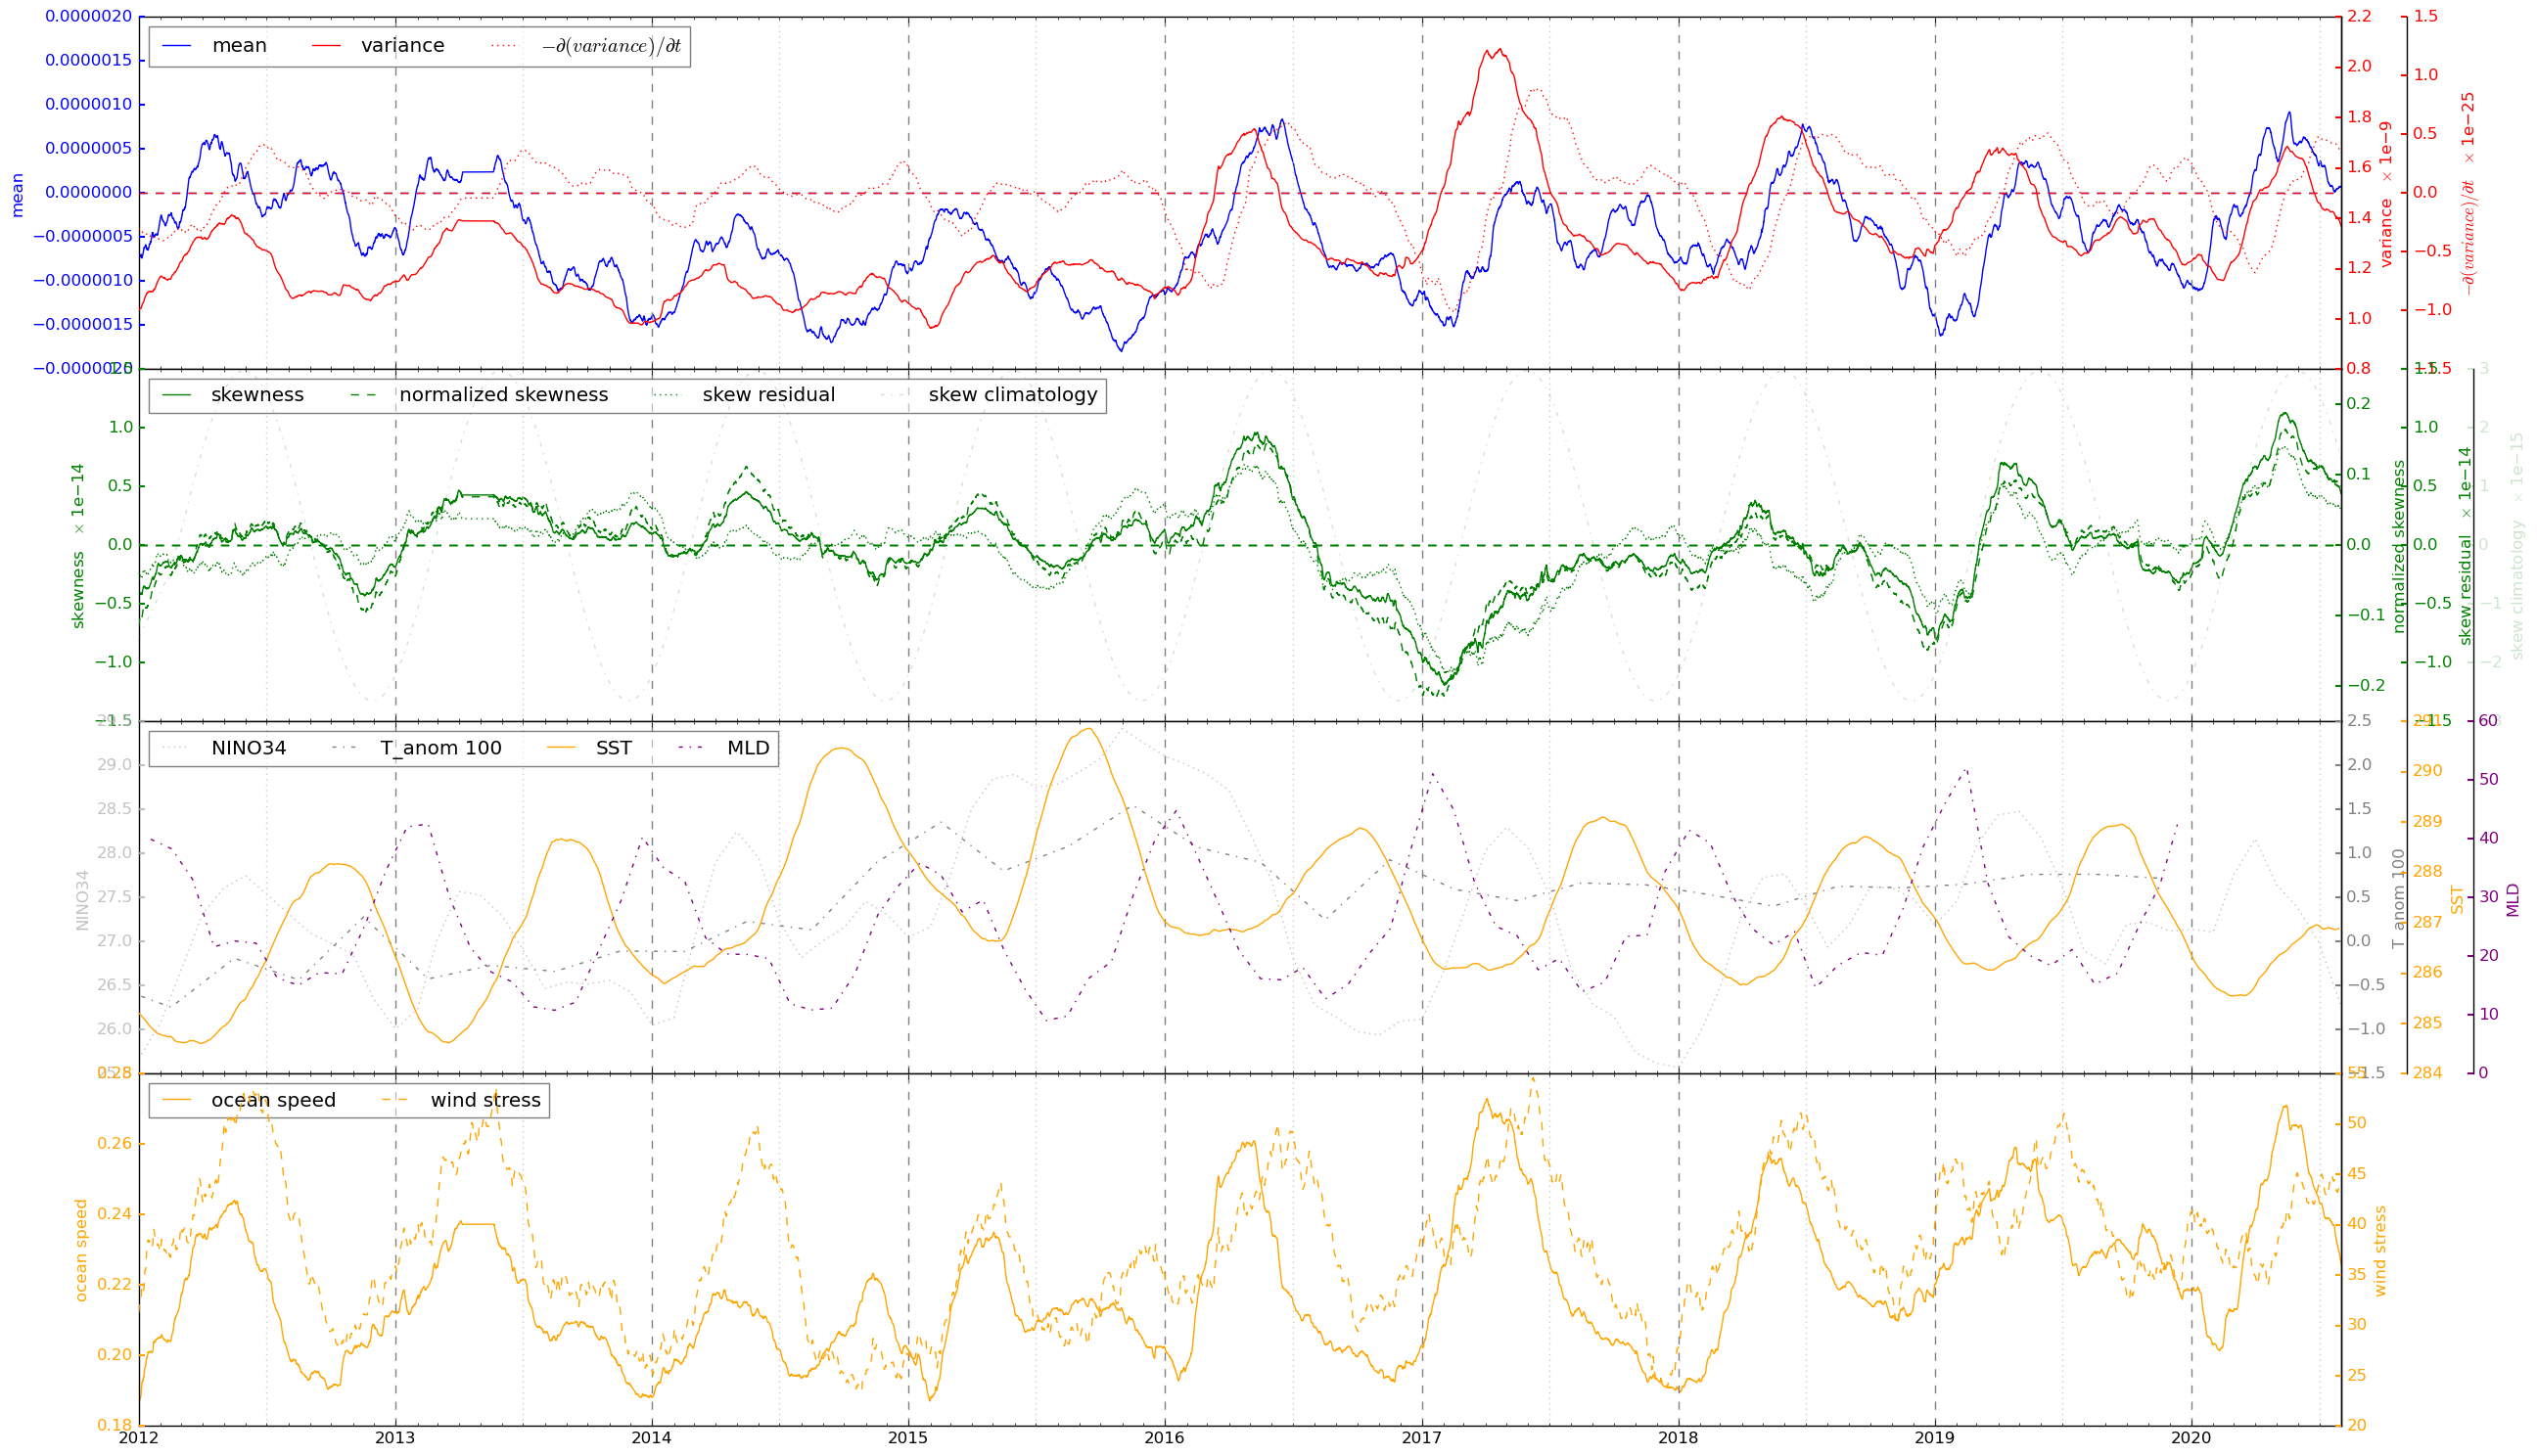

In [65]:
# Conciseness shortcut
cl = clim_sets
ht = heat_sets
E5 = ERA5_data
# Setup
data             = [mean    , var       , neg_dvar_dt, skew      , skew_norm            , skew_residual  , skew_climo        , clim_ind[0]  , heat_ind[2]  , E5['sst'], mld     , speed.sel(moment=1), E5['wind_stress'] ] 
labels           = ['mean'  , 'variance', dvardt_str , 'skewness', 'normalized skewness', 'skew residual', 'skew climatology', cl[0]['name'], ht[2]['name'], 'SST'    , 'MLD'   , 'ocean speed'      , 'wind stress'     ] 
colors           = ['b'     , 'r'       , 'r'        , 'g'       ,'g'                   , 'g'            , [0, .5, 0, .2]    , [.7,.7,.7,.8], [.5,.5,.5,1] , 'orange' , 'purple', 'orange'           , 'orange'          ]
linestyles       = ['-'     , '-'       ,'dotted'    , '-'       , '--'                 , 'dotted'       , '-.'              , 'dotted'     , '-.'         , '-'      , '-.'    , '-'                , '--'              ]
time_smoothing   = [t_smooth, t_smooth  , t_smooth   , t_smooth  , t_smooth             , t_smooth       , t_smooth          ,  1           , 1            , t_smooth , 1       , t_smooth           , t_smooth          ]
zero_center      = [True    , False     , True       , True      , True                 , True           , True              , False        , False        , False    , False   , False              , False             ]   
zero_line        = [True    , False     , True       , True      , True                 , True           , True              , False        , False        , False    , False   , False              , False             ]
frame            = [0       , 0         , 0          , 1         , 1                    , 1              , 1                 , 2            , 2            , 2        , 2       , 3                  , 3                 ]


frames           = set(frame) # list of the unique frames
frame_groups     = personal.data_structures.get_indices(frame,frames) # group the lines going in each frame

L                = len(frames)
fig,host         = plt.subplots(L,  figsize=(3600/dpi,1800/dpi),dpi=dpi, sharex=True,facecolor='white') # share the x axis, host is a list of axes for the subplot | # fig, host = plt.subplots(figsize=(3600/dpi,900/dpi),dpi=dpi)
# fig.patch.set_alpha(0)  # solution


fig.subplots_adjust(hspace=0) # remove height spacing between subplots
fig.subplots_adjust(right=0.75)

axes = {i:[host[i]] for i in range(L)}
for i in range(L):
#     axes[i][0].patch.set_alpha(0)
    axes[i] = axes[i] + [axes[i][0].twinx() for x in range(len(frame_groups[i])-1)] # generate twin axes for multiline subplots, (i and frame are in theory equal)

tkw              = dict(length=4, width=1.5) # not sure what this does

reload(personal.plots)
p   = {j:{} for j in range(L)} # plots
for j in range(L): # the frame we're in
    for i in range(len(frame_groups[j])): # the line in that frame
        n = frame_groups[j][i] # the number of the line 
        print(str(n+1) + '/' + str(len(frame)))
        if i is not 0:
            axes[j][i].spines["right"].set_position(("axes", 1 + .03*(i-1))) # Offset the right spine of par2. The ticks and label have already been placed on the right by twinx above.
            personal.plots.make_patch_spines_invisible(axes[j][i]) # Having been created by twinx, par2 has its frame off, so the line of its detached spine is invisible.  First, activate the frame but make the patch and spines invisible.
            axes[j][i].spines["right"].set_visible(True)
        y = data[n].rolling(time=time_smoothing[n],center=True,min_periods=1).mean()
        t = y['time']
        p[j][i], = axes[j][i].plot(t,y,color=colors[n],linestyle=linestyles[n],label=labels[n])
        axes[j][i].axhline(0, color=colors[n], linestyle='--') if zero_line[n] else None
        personal.plots.Labeloffset(axes[j][i], label=labels[n], axis="y") # add label objects that move offset exponent to along axis spine
        axes[j][i].yaxis.label.set_color(colors[n])
        axes[j][i].tick_params(axis='y', colors=colors[n], **tkw)
        axes[j][i].set_ylim(ymin=-abs(max(axes[j][i].get_ylim(), key=abs)), ymax=abs(max(axes[j][i].get_ylim(), key=abs))) if zero_center[n] else None # center about 0
        axes[j][i].set_xlim(xmin=np.datetime64('2012-01-01'),xmax=np.datetime64('2020-08-01'))
#   axes[j][i].minorticks_on()
    axes[j][0].xaxis.set_minor_locator(mdates.MonthLocator())
    axes[j][0].tick_params(axis='x',direction="in", which="both", top=True)#get_xticks(), rotation=0)


[axes[j][0].axvline(dt.datetime(x,1,1),color=[.5,.5,.5],linestyle='--')     for x in list(range(int(stats_fulltime.time[0].dt.year+1),int(stats_fulltime.time[-1].dt.year+1))) for j in range(L)] # draw vertial year lines
[axes[j][0].axvline(dt.datetime(x,7,1),color=[.8,.8,.8],linestyle='dotted') for x in list(range(int(stats_fulltime.time[0].dt.year  ),int(stats_fulltime.time[-1].dt.year+1))) for j in range(L)] # draw vertial year lines

import matplotlib.dates as mdates
# axes[L-1][0].xaxis.set_minor_locator(mdates.MonthLocator())
[axes[j][0].legend(p[j].values(), [l.get_label() for l in p[j].values()],loc='upper left',ncol=len(p[j]),framealpha=0.5) for j in range(L)]

print('done')

In [93]:
#%% Save Figure
fig.savefig('../Figures/vorticity_stats_post_smoothed.pdf',transparency=True)


In [ ]:
#%% Save as function "read_csv_preprocess" probably in data structures? Or make a new module called IO. Allow passing arbitrary fcn where we did re.sub
url = "https://www.ncdc.noaa.gov/teleconnections/pdo/data.txt"                      ; skip_row=2; skip_foot=0; na=-99.99 # PDO                    

        


In [ ]:
i = 0
enso = xr.open_dataset("../Data/miscellaneous/" + filenames[i],decode_cf=False,decode_times=True)
enso['time'] = np.array([np.datetime64('1955-01') + np.timedelta64(int(x.values-0.5),'M') + np.timedelta64(15,'D') for x in enso['time']])
enso = personal.SMODE.select_SMODE_region(enso[vars_in[i]])
enso = enso.where(enso < 1e10,other=np.nan)
enso = enso.mean(dim=[dim for dim in enso.dims if dim not in 'time'],skipna=True)
enso.time.values
enso = enso.chunk({'time':5})
diff_enso = enso.differentiate('time')



In [ ]:
print(enso['time'])
# enso['time']
# [np.timedelta64(float(x.values),'M') for x in enso['time']] 
# np.timedelta64(enso['time'][0].values - 0.5,'M')
# np.timedelta64(enso['time'][0].values - 0.5)
# np.relativedelta()

In [ ]:
fft_smoothed = pdo.xr_groupby_strftime(pdo.xr_drop_leap_days(vor.sel(moment=1)), strfmt='%m-%d %H',new_time_name='time').mean() # could try %m-%d %H also... or without %H
fft_smoothed.values  = ps.climatology(fft_smoothed.values,dim=0,harmonics=[0,1])
fft_smoothed = personal.data_structures.xr_repeat(fft_smoothed,n=2020-2012+1,dim='time',extrapolate_dim=False)
fft_smoothed['time'] = pdo.drop_leap_days(np.arange(np.datetime64('2012-01-01 00:00'), np.datetime64('2021-01-01 00:00'), np.timedelta64(1,'h')))
#                  pdo.xr_groupby_strftime(pdo.xr_drop_leap_days(vor.sel(moment=1)), strfmt='%Y-%m-%d'   ,new_time_name='time').mean() # for daily res
original_data = pdo.xr_drop_leap_days(vor.sel(moment=1))#just needs to match resolution above...

In [ ]:
print(original_data)
print('----')
print(fft_smoothed)
print('----')
print(slice(original_data.time.values[0],original_data.time.values[-1]))
# .rolling(time=time_smoothing[i],center=True,min_periods=1).mean()
fft_smoothed2 = fft_smoothed.sel(time=slice(original_data['time'].values[0],original_data['time'].values[-1]))# - original_data.values
print(len(fft_smoothed2['time'].values))
print(len(original_data['time'].values))
np.arange(original_data['time'].values[0],original_data['time'].values[-1], np.timedelta64(1,'h'))

In [ ]:
reload(personal.data_structures)
mld = xr.open_mfdataset("../Data/miscellaneous/dsrs.atmos.umd.edu/DATA/soda3.4.2/REGRIDED/ocean/*nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal")
mld = mld.rename({'xt_ocean':'lon', 'yt_ocean':'lat'})
mld = personal.data_structures.xr_shift_coord(mld,coord='lon',old_range_lower_bound=0, new_range_lower_bound=-180, v_range=360, inclusive_upper_bound=False,shift_sorted_dim=True)
mld = mld['mlt']
# mld = mld['mlt'].to_dataset(name='MLD')
mld = personal.SMODE.select_SMODE_region(mld)
mld = mld.mean(dim=[dim for dim in mld.dims if dim not in 'time'],skipna=True)
mld.values


In [ ]:

# fft_smoothed = pdo.xr_groupby_strftime(pdo.xr_drop_leap_days(vor.sel(moment=1)), strfmt='%m-%d %H',new_time_name='time').mean() # could try %m-%d %H also... or without %H
# fft_smoothed.values  = ps.climatology(fft_smoothed.values,dim=0,harmonics=[0,1])
# fft_smoothed = personal.data_structures.xr_repeat(fft_smoothed,n=2020-2012+1,dim='time',extrapolate_dim=False)
# fft_smoothed['time'] = pdo.drop_leap_days(np.arange(np.datetime64('2012-01-01 00:00'), np.datetime64('2021-01-01 00:00'), np.timedelta64(1,'h')))
fft_smoothed.sel(time=original_data['time']) - original_data

In [ ]:
new_time = np.arange(np.datetime64('2012-01-01'), np.datetime64('2021-01-01'), np.timedelta64(1,'D'))
new_time

fft_smoothed = fft_smoothed[0:3]
fft_smoothed = personal.data_structures.xr_repeat(fft_smoothed,n=2,dim='time',extrapolate_dim=True)
fft_smoothed.time.values

In [ ]:
import cdsapi # see https://cds.climate.copernicus.eu/api-how-to
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', 'sea_surface_temperature',
        ],
        'year': [
            '2012', '2013', '2014'
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            40, -125, 35,
            -120,
        ],
        'format': 'grib',
    },
    'ERA_5_winds_2012_2014.nc')

In [ ]:
ERA5_data = xr.open_mfdataset("../Data/miscellaneous/ERA_5*.nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal").chunk({'time':24*365})
ERA5_data = ERA5_data.rename({"longitude":"lon",'latitude':"lat", 'u10':'u','v10':'v'})
ERA5_data = ERA5_data.sortby(ERA5_data.lat,ascending=True)
# ERA5_data = personal.SMODE.select_SMODE_region(ERA5_data)
    
ERA5_data = xr.apply_ufunc(lambda x: personal.data_structures.replace_nan_from_array(x[:,:,:,0],x[:,:,:,1]),
               ERA5_data,
               input_core_dims = [["expver"]], # dims we mut have
               output_core_dims = [[]],        # dims output must have
               vectorize = False,   
               keep_attrs = False,
               dask = "parallelized",          # ’forbidden’ (default): raise an error if a dask array is encountered. ’allowed’: pass dask arrays directly on to func. ’parallelized’: automatically parallelize func if any of the inputs are a dask array. If used, the output_dtypes argument must also be provided. Multiple output arguments are not yet supported.
               output_dtypes=[ERA5_data['v'].dtype])
               
ERA5_data['speed']            = (ERA5_data['u']**2  + ERA5_data['v']**2)**(1./2)
ERA5_data['wind_stress']      = ERA5_data['speed']**2
ERA5_data = ERA5_data.mean(dim=[dim for dim in ERA5_data.dims if dim not in 'time'],skipna=True)

ERA5_data['u']

In [ ]:
ERA5_data = xr.open_mfdataset("../Data/miscellaneous/ERA_5*.nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal").chunk({'time':10000})
ERA5_data = ERA5_data.rename({"longitude":"lon",'latitude':"lat", 'u10':'u','v10':'v'})
ERA5_data = ERA5_data.sortby(ERA5_data.lat,ascending=True)
ERA5_data = personal.SMODE.select_SMODE_region(ERA5_data,rechunk=False)
ERA5_data = xr.apply_ufunc(lambda x: personal.data_structures.replace_nan_from_array(x[:,:,:,0],x[:,:,:,1]), ERA5_data, input_core_dims = [["expver"]], output_core_dims = [[]], vectorize = False, keep_attrs = False, dask = "parallelized", output_dtypes=[ERA5_data['v'].dtype])              

ERA5_data['wind_stress']  = ERA5_data['u']**2  + ERA5_data['v']**2
ERA5_data = ERA5_data.mean(dim=[dim for dim in ERA5_data.dims if dim not in 'time'],skipna=True)



# ERA5_data = xr.open_mfdataset("../Data/miscellaneous/ERA_5*.nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal").chunk({'time':1})
# ERA5_data['u'][10500:11500].values
ERA5_data.load()

In [ ]:
ERA5_data = xr.open_mfdataset("../Data/miscellaneous/ERA_5*.nc",decode_cf=True, decode_times=True,combine='by_coords',data_vars="minimal")
ERA5_data = ERA5_data.rename({"longitude":"lon",'latitude':"lat", 'u10':'u','v10':'v'})
print(ERA5_data)
ERA5_data = personal.SMODE.select_SMODE_region(ERA5_data)
print(ERA5_data)
# ERA5_data['speed'] = 
print(ERA5_data['u'][0,0,0,0].values)

In [ ]:
np.count_nonzero(~np.isnan(ERA5_data['v10'].values),axis=3)
print(np.count_nonzero(~np.isnan(valid)))
np.size(valid)

# ERA5_data.values

In [ ]:
import pandas as pd
import urllib




# plt.plot(g.index,g.values)
# c.columns = ['a_' + str(x) for x in list(range(1,13))]
# print(c)
# d  = c.to_xarray()
# d = xr.DataArray.from_series(c)
# d = xr.Dataset.from_dataframe(c)
# d
# print(d)
# c.to_numpy()
# c.stack()

In [ ]:
import matplotlib.pyplot as plt

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# fig,host  = plt.figure
fig, host = plt.subplots(figsize=(3600/dpi,900/dpi),dpi=dpi)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

# p1, = stats_fulltime['vorticity'].sel(moment=1).plot( "b-", label="mean")
# p2, = stats_fulltime['vorticity'].sel(moment=2).plot( "b-", label="variance")
# p3, = stats_fulltime['vorticity'].sel(moment=3).plot( "b-", label="skewness")

p1, = host.plot(stats_fulltime['time'], stats_fulltime['vorticity_2'].sel(moment=1), "b-", label="mean")
p2, = par1.plot(stats_fulltime['time'], stats_fulltime['vorticity_2'].sel(moment=2), "r-", label="variance")
p3, = par2.plot(stats_fulltime['time'], stats_fulltime['vorticity_2'].sel(moment=3), "g-", label="skewness")

# host.set_xlim(0, 2)
# host.set_ylim(0, 2)
# par1.set_ylim(0, 4)
# par2.set_ylim(1, 65)

# host.set_xlabel("Distance")
host.set_ylabel("mean")
par1.set_ylabel("variance")
par2.set_ylabel("skewness")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines])

plt.show()

In [ ]:
#%% Calculate vor properties
print(vor)
print(vor.shape)
counts, bins = np.histogram(vor.where(np.abs(vor) != np.nan)) # fails on [nan nan] range for some reason...

#np.nanmean(vor)

plt.figure(figsize=(960/dpi,900/dpi),dpi=dpi)
#plt.hist(bins[:-1], bins, weights=counts)
#plt.hist(bins[:-1], bins, weights=counts)
#vor_sq = vor**2
vor.plot.hist(bins=200,density=True)
ax.set_ylim([-.00015, .00015]);
plt.yscale('log'),
plt.rcParams.update({'font.size': 12})
plt.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=0.99)
plt.show()